In [1]:
#Run this to troubleshoot some problem with the cairo library (happens in macos)
#Also, need to add to settings.json the following:
#"terminal.integrated.env.osx": {
#     "DYLD_LIBRARY_PATH": "/opt/homebrew/opt/cairo/lib:${env:DYLD_LIBRARY_PATH}"
# },

import os
os.environ['DYLD_LIBRARY_PATH'] = '/opt/homebrew/opt/cairo/lib:$DYLD_LIBRARY_PATH'



In [2]:
import sys
sys.path.append('/Users/evatakou/noise_est')
# from color_code_stim import *
from color_code_stim_copy import *
from noise_est_funcs_for_color_code import *
from utilities_for_color_code import *
from numerical_equations_for_color_code import *
from construct_dem import *
from defects_matrix_construction import *
import matplotlib
from matplotlib import pyplot as plt 
from utilities.general_utils import *

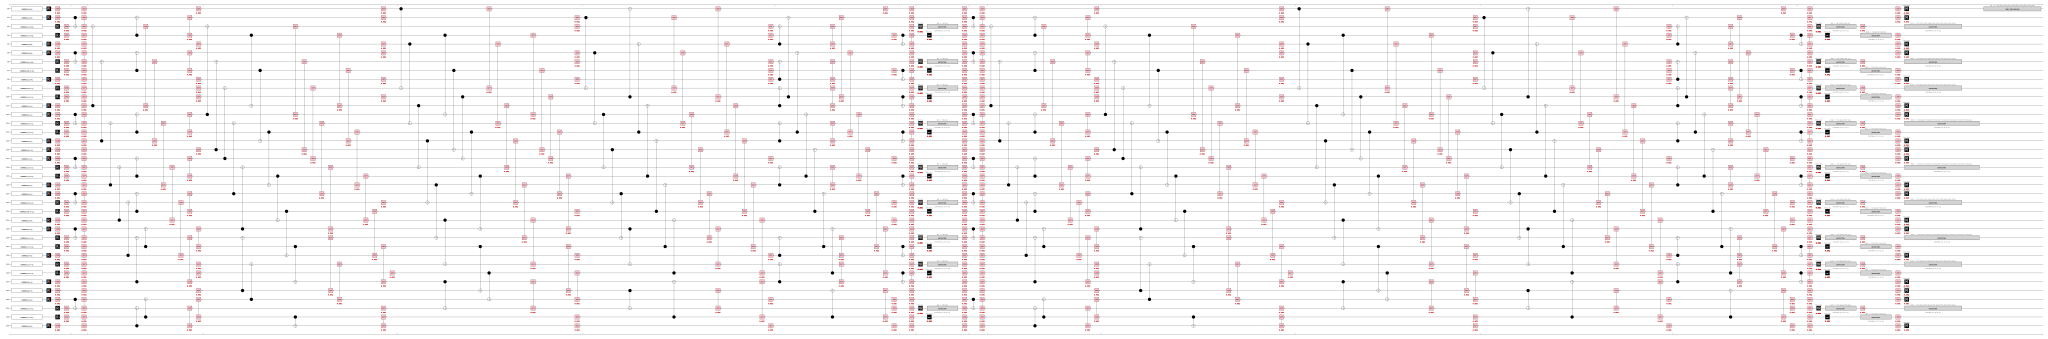

In [3]:
d          = 5
num_rounds = 2
p_circuit  = 2e-3
obj        = ColorCode(d=d,rounds=num_rounds,p_circuit=p_circuit) ##p_cnot=0,p_bitflip=0.01, p_circuit=1e-2 ,
circuit    = obj.circuit

circuit.diagram("timeline-svg")


In [4]:
num_ancilla   = len(obj.qubit_groups['anc'])
Z_dets,X_dets = get_Z_X_det_nodes(obj,num_rounds)
Z_DEM,X_DEM   = decompose_org_DEM_into_ZX_DEMs(circuit,Z_dets,X_dets)

In [5]:
dems_stim                     = {}


for color in ["r", "g", "b"]: 
    # dem1,dem2        = obj.get_decomposed_dems(color)
    dem1,dem2 = obj.decompose_detector_error_model([],color)
    dems_stim[color] = dem1, dem2  
    

In [6]:
dets_Z,dets_X = get_Z_X_det_nodes_as_rd_anc_pairs_dict(obj,num_rounds)


In [7]:
num_shots = 5*10**7
defects_matrix_Z,defects_matrix_X,data_qubit_samples,Z_ANC_QUBITS,X_ANC_QUBITS = get_defects(circuit,num_rounds,num_shots,obj)

min_bound = 1e-12
max_bound = 0.6      
method    = "least_squares"  

vi_mean_Z   = avg_vi(defects_matrix_Z)
vivj_mean_Z = avg_vivj(defects_matrix_Z.data)


In [8]:
p3_cnts_for_Z  = get_3_pnt_events_Z_DEM(defects_matrix_Z,obj,Z_DEM)
detector_type  = "Z"
vijk_for_Z     = get_vijk(p3_cnts_for_Z,num_rounds,vi_mean_Z,vivj_mean_Z,obj,detector_type)
sols_for_Z     = solve_for_probs(min_bound,max_bound,method,vijk_for_Z)

if len(defects_matrix_X)>0: #non-empty

    vi_mean_X      = avg_vi(defects_matrix_X) 
    vivj_mean_X    = avg_vivj(defects_matrix_X.data) 
    p3_cnts_for_X  = get_3_pnt_events_X_DEM(defects_matrix_X,obj,X_DEM,num_rounds) 
    detector_type  = "X" 
    vijk_for_X     = get_vijk(p3_cnts_for_X,num_rounds,vi_mean_X,vivj_mean_X,obj,detector_type) 
    sols_for_X     = solve_for_probs(min_bound,max_bound,method,vijk_for_X) 


In [9]:
#Get the edges for the Z_DEM
sols_for_defect_type           = sols_for_Z    
vi_mean                        = vi_mean_Z  
vivj_mean                      = vivj_mean_Z     
stims_DEM                      = Z_DEM    
defects_type                   = "Z" 
pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type) 
error_events_in_Z_DEM,my_Z_DEM = create_Z_DEM(pij_bd,pij_bulk,pij_time,p3,Z_DEM) 


In [10]:
def relative_error_of_edges(stims_DEM,my_DEM):

    errors_in_stims_DEM = DEM_to_dictionary(stims_DEM)
    errors_in_my_DEM    = DEM_to_dictionary(my_DEM)

    rel_error_p3 = {}
    rel_error_p2 = {}
    rel_error_p1 = {}

    bd_stim = {}
    bd_mine = {}
    for key in errors_in_stims_DEM.keys():

        p_true  = errors_in_stims_DEM[key]
        p_est   = errors_in_my_DEM[key]

        if len(key)==3:
            if key[1]=="L0":
                rel_error_p2[key] = abs(p_true-p_est)/p_true 
            else:
                rel_error_p3[key] = abs(p_true-p_est)/p_true 
                
        if len(key)==2:
            
            if key[1]=="L0":
                
                rel_error_p1[key] = abs(p_true-p_est)/p_true 
                bd_stim[key] = p_true 
                bd_mine[key] = p_est

            else:
                rel_error_p2[key] = abs(p_true-p_est)/p_true 


        if len(key)==1:
            rel_error_p1[key] = abs(p_true-p_est)/p_true
            bd_stim[key] = p_true 
            bd_mine[key] = p_est


    return rel_error_p1, rel_error_p2, rel_error_p3, bd_stim,bd_mine

bd_stim: {('D1', 'L0'): 0.009129115831254796, ('D2', 'L0'): 0.006500628512183747, ('D3',): 0.002397155555555376, ('D4', 'L0'): 0.0010666666666665158, ('D5', 'L0'): 0.0010666666666665158, ('D7',): 0.002397155555555376, ('D8',): 0.0038580663196391644, ('D10', 'L0'): 0.013173771222226054, ('D11', 'L0'): 0.009520585908981699, ('D12',): 0.0034587082903700423, ('D13', 'L0'): 0.0021310577777774774, ('D14', 'L0'): 0.0021310577777774774, ('D16',): 0.002397155555555376, ('D17',): 0.009520585908981699, ('D32', 'L0'): 0.0010666666666665158, ('D28', 'L0'): 0.008078983962314644, ('D29', 'L0'): 0.007027308887942401, ('D31', 'L0'): 0.0010666666666665158, ('D30',): 0.0010666666666665158, ('D35',): 0.009652990990292074}
bd_mine: {('D1', 'L0'): 0.00913539889097692, ('D2', 'L0'): 0.006484544064525755, ('D3',): 0.00239876357464347, ('D4', 'L0'): 0.0010611381848978363, ('D5', 'L0'): 0.001073815435413017, ('D7',): 0.0023902491019735517, ('D8',): 0.0038461981437503123, ('D10', 'L0'): 0.013166771879004502, ('D

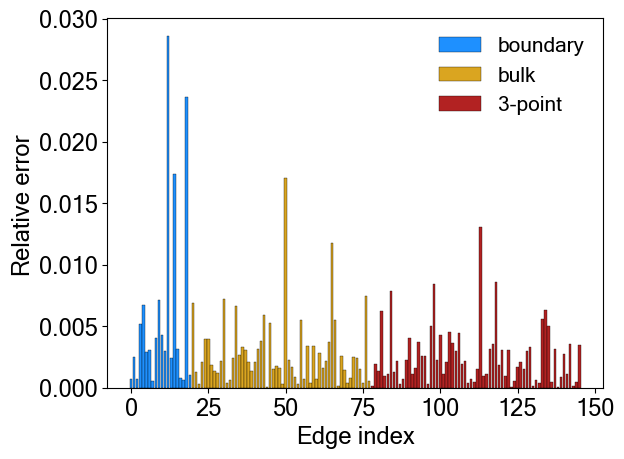

In [ ]:
#Compare the edges of the 2 Z-DEMs

rel_error_p1, rel_error_p2, rel_error_p3, bd_stim,bd_mine = relative_error_of_edges(Z_DEM,my_Z_DEM)

fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"    

x1 = np.arange(len(rel_error_p1.keys()))
x2 = np.arange(x1[-1]+1,len(rel_error_p2.keys())+x1[-1]+1)
x3 = np.arange(x2[-1]+1,len(rel_error_p3.keys())+x2[-1]+1)

plt.bar(x=x1,height=list(rel_error_p1.values()),
        edgecolor='black',linewidth=0.25,
        facecolor='dodgerblue')

plt.bar(x=x2,height=list(rel_error_p2.values()),
        edgecolor='black',linewidth=0.25,
        facecolor='goldenrod')

plt.bar(x=x3,height=list(rel_error_p3.values()),
        edgecolor='black',linewidth=0.25,
        facecolor='firebrick')

plt.legend(['boundary','bulk','3-point'],
           frameon=False,shadow=True,fontsize=15,)

plt.xlabel('Edge index')
plt.ylabel('Relative error')

# fig.savefig("Rel_Edge_Error_d_5_r_2_p_circ_2e_minus_3_N_est_5_10_7_Z_DEM.pdf",bbox_inches='tight')

print("bd_stim:",bd_stim)
print("bd_mine:",bd_mine)

In [11]:
#Get the edges for the X_DEM
if len(defects_matrix_X)>0:

    sols_for_defect_type           = sols_for_X
    vi_mean                        = vi_mean_X 
    vivj_mean                      = vivj_mean_X 
    stims_DEM                      = X_DEM 
    defects_type                   = "X"
    pij_bulk,pij_time,pij_bd,p3    = estimate_all_edges_for_defect_type(sols_for_defect_type,obj,num_rounds,vi_mean,vivj_mean,stims_DEM,defects_type)
    error_events_in_X_DEM,my_X_DEM = create_X_DEM(pij_bd,pij_bulk,pij_time,p3,X_DEM)
else:
    my_X_DEM = {}

bd_stim: {('D23',): 0.032039719951632406, ('D21',): 0.034779633091657255, ('D18',): 0.030538913652573826, ('D24',): 0.030035340907572566, ('D22',): 0.027014013296434602, ('D19',): 0.04046044978679573, ('D26',): 0.0340355504053365, ('D20',): 0.03799973370176549, ('D25',): 0.03028719476425938}
bd_mine: {('D23',): 0.03207736485964957, ('D21',): 0.034809126485883635, ('D18',): 0.030574589567705368, ('D24',): 0.03006544765427216, ('D22',): 0.027056926722456798, ('D19',): 0.04046035802674647, ('D26',): 0.0340661711063846, ('D20',): 0.03797843077349078, ('D25',): 0.030332824754212673}


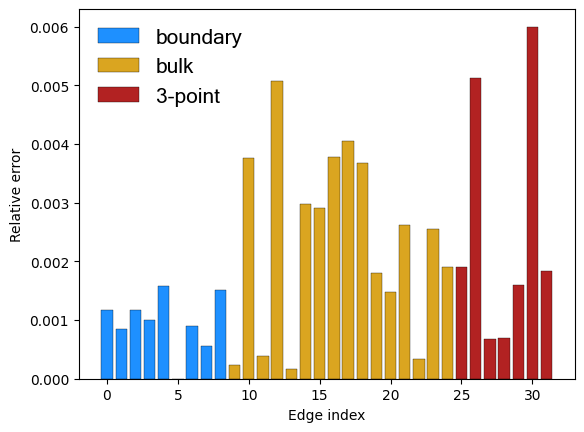

In [12]:
#Compare the edges of the 2 X-DEMs

rel_error_p1, rel_error_p2, rel_error_p3, bd_stim,bd_mine = relative_error_of_edges(X_DEM,my_X_DEM)

fig, ax = plt.subplots()

matplotlib.rcParams.update({'font.size': 17})
plt.rcParams["font.family"] = "Microsoft Sans Serif"    


x1 = np.arange(len(rel_error_p1.keys()))
x2 = np.arange(x1[-1]+1,len(rel_error_p2.keys())+x1[-1]+1)
x3 = np.arange(x2[-1]+1,len(rel_error_p3.keys())+x2[-1]+1)

plt.bar(x=x1,height=list(rel_error_p1.values()),
        edgecolor='black',linewidth=0.25,
        facecolor='dodgerblue')

plt.bar(x=x2,height=list(rel_error_p2.values()),
        edgecolor='black',linewidth=0.25,
        facecolor='goldenrod')

plt.bar(x=x3,height=list(rel_error_p3.values()),
        edgecolor='black',linewidth=0.25,
        facecolor='firebrick')

plt.legend(['boundary','bulk','3-point'],
           frameon=False,shadow=True,fontsize=15,)

plt.xlabel('Edge index')
plt.ylabel('Relative error')

# fig.savefig("Rel_Edge_Error_d_5_r_2_p_circ_2e_minus_3_N_est_5_10_7_X_DEM.pdf",bbox_inches='tight')

print("bd_stim:",bd_stim)
print("bd_mine:",bd_mine)